# Helper Methods

In [1]:
import numpy as np

# outlier removal method: IQR
# returns list without outliers
# http://colingorrie.github.io/outlier-detection.html
# https://machinelearningmastery.com/how-to-use-statistics-to-identify-outliers-in-data/
def remove_outliers_iqr(data):
    quartile_1, quartile_3 = np.percentile(data, [25, 75])
    iqr = quartile_3 - quartile_1
    cut_off = (iqr * 1.5)
    lower_bound = quartile_1 - cut_off
    upper_bound = quartile_3 + cut_off
    # identify outliers
    outliers = [x for x in data if x < lower_bound or x > upper_bound]
    print('Identified outliers: %d' % len(outliers))
    # remove outliers
    outliers_removed = [x for x in data if x >= lower_bound and x <= upper_bound]
    print('Non-outlier observations: %d' % len(outliers_removed))
    return outliers_removed

# annotates plt with y values
def plot_annotate(plt,xvalues,yvalues):
    for i,j in zip(xvalues, yvalues):
        plt.annotate(str(np.round(j,1)),xy=(i-0.15,j))
        
def autolabel_barchart(rects,axis):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        axis.text(rect.get_x() + rect.get_width()/2., 0.9*height,'%.1f' % round(float(height),1),ha='center', va='bottom')
    

# PyMongo Query

db = "test"
collection = "benchmarklogs"

In [2]:
from pymongo import MongoClient
client = MongoClient()

db = client['test']
collection = db['benchmarklogs']

# PyMongo Query ->Pandas DataFrame

In [3]:
import pandas as pd

query = {"$and":[ {"$or":[ {"scenario":"account"}, {"scenario":"ballot"}]}, 
        {"usedGenesisJson":"genesis_pow_default.json"}, {"maxTransactions": 1000}, {"instanceType":'c5.xlarge'}, {"nodes":5}]}

# query = {}

# Make a query to the specific DB and Collection
cursor = collection.find(query)

# Expand the cursor and construct the DataFrame
df = pd.DataFrame(list(cursor))

#display(df.head(200))

sample_size = len(df.index)
print("Number of rows:" + str(sample_size))

Number of rows:100


# Pandas DataFrame -> Plot
## Throughput

In [4]:
import matplotlib.pyplot as plt

data_tps = df[['txPerSecond','scenario']]

title_tps = "Throughput against Workload Type (PoW, n=" + str(sample_size) + ")"
xlabel = "Workload Type"
ylabel = "Transactions Per Second (TPS)"

objects = list(["Account","Ballot"])

data1_tps = data_tps.loc[df['scenario'] == "account"].iloc[:,0]
data2_tps = data_tps.loc[df['scenario'] == "ballot"].iloc[:,0]

# REMOVE OUTLIERS
data1_tps = pd.Series(remove_outliers_iqr(data1_tps))
data2_tps = pd.Series(remove_outliers_iqr(data2_tps))

## combine these different collections into a list    
data_to_plot_tps = [data1_tps, data2_tps]

avg1_tps = data1_tps.mean()
avg2_tps = data2_tps.mean()

means_tps = [avg1_tps, avg2_tps]

print(avg1_tps)
print(avg2_tps)

Identified outliers: 3
Non-outlier observations: 47
Identified outliers: 8
Non-outlier observations: 42
71.67715287176864
68.71624173962974


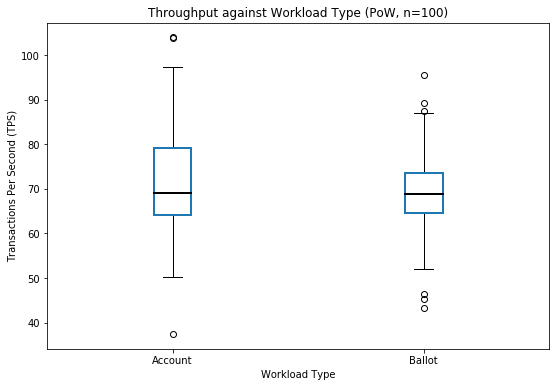

In [5]:
color_latency="#ff7f0e"
color_tps="#1f77b4"

fig = plt.figure(1, figsize=(9, 6))

# Create an axes instance
ax = fig.add_subplot(111)

ax.set_title(title_tps)
ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)

# Create the boxplot
bp = ax.boxplot(data_to_plot_tps,labels=objects, patch_artist=True)

## change outline color, fill color and linewidth of the boxes
for box in bp['boxes']:
    # change outline color
    box.set( color=color_tps, linewidth=2)
    # change fill color
    box.set( facecolor = 'w' )
    
## change color and linewidth of the medians
for median in bp['medians']:
    median.set(color="k", linewidth=2)

fig.savefig("result_workload_pow_throughput_boxplot.svg", format="svg")

## Latency

In [6]:
import matplotlib.pyplot as plt

data_latency = df[['averageDelay','scenario']]

title_latency = "Latency against Workload Type (PoW, n=" + str(sample_size) + ")"
xlabel = "Workload Type"
ylabel = "Average Transaction Latency [seconds]"

objects = list(["Account","Ballot"])

data1_latency = data_latency.loc[df['scenario'] == "account"].iloc[:,0]
data2_latency = data_latency.loc[df['scenario'] == "ballot"].iloc[:,0]

# REMOVE OUTLIERS
data1_latency = pd.Series(remove_outliers_iqr(data1_latency))
data2_latency = pd.Series(remove_outliers_iqr(data2_latency))

## combine these different collections into a list    
data_to_plot_latency = [data1_latency,data2_latency]

avg1_latency = data1_latency.mean()
avg2_latency = data2_latency.mean()

means_latency = [avg1_latency, avg2_latency]

print(avg1_latency)
print(avg2_latency)

Identified outliers: 3
Non-outlier observations: 47
Identified outliers: 3
Non-outlier observations: 47
7.702220234042554
8.098874681767285


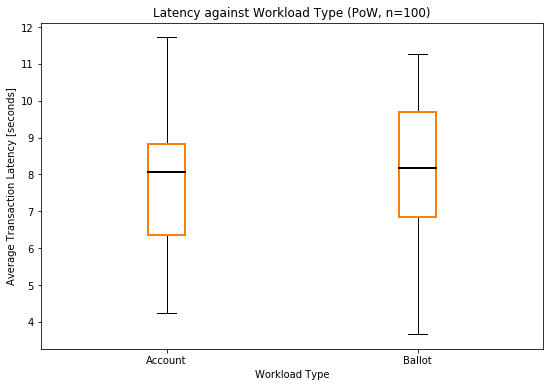

In [7]:
fig = plt.figure(1, figsize=(9, 6))

# Create an axes instance
ax = fig.add_subplot(111)

ax.set_title(title_latency)
ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)

# Create the boxplot
bp = ax.boxplot(data_to_plot_latency,labels=objects, patch_artist=True)

## change outline color, fill color and linewidth of the boxes
for box in bp['boxes']:
    # change outline color
    box.set( color=color_latency, linewidth=2)
    # change fill color
    box.set( facecolor = 'w' )
    
## change color and linewidth of the medians
for median in bp['medians']:
    median.set(color="k", linewidth=2) 
    
fig.savefig("result_workload_pow_latency_boxplot.svg", format="svg")

## Throughput and Latency Combined

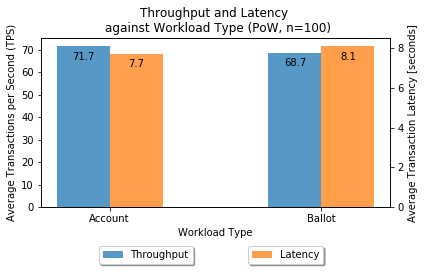

In [8]:
df1 = pd.DataFrame({'Average Throughput [TPS]':means_tps})
df2 = pd.DataFrame({'Average Latency [seconds]':means_latency})

fig = plt.figure()
ax1 = fig.add_subplot(111)

## the data
N = 2
## necessary variables
ind = np.arange(N)                # the x locations for the groups
width = 0.25                      # the width of the bars

## the bars
rects1 = ax1.bar(ind, means_tps, width, color=color_tps, alpha=0.75, label="Throughput")
ax1.set_ylabel("Average Transactions per Second (TPS)")
ax1.set_xlabel(xlabel)

ax2 = ax1.twinx()
rects2 = ax2.bar(ind+width, means_latency, width,color=color_latency, alpha=0.75, label="Latency")
ax2.set_ylabel("Average Transaction Latency [seconds]")

# axes and labels
#ax1.set_xlim(-width,len(ind)+width)
ax1.set_title("Throughput and Latency \n against Workload Type (PoW, n=" + str(sample_size) + ")")
ax1.set_xticks(ind + width / 2)
ax1.set_xticklabels(('Account', 'Ballot'))

## add a legend
#ax1.legend((rects1[0], rects2[0]), ('TPS', 'Latency') )

ax1.legend(loc='upper center', bbox_to_anchor=(0.3, -0.2),
          ncol=3, fancybox=True, shadow=True)

ax2.legend(loc='upper center', bbox_to_anchor=(0.7, -0.2),
          ncol=3, fancybox=True, shadow=True)

autolabel_barchart(rects1,ax1)
autolabel_barchart(rects2,ax2)

#ax1.set_ylim(ymax=100)
#ax2.set_ylim(ymax=10)

fig.tight_layout()
ax1.figure.savefig("result_workload_pow_combined_barchart.svg", format="svg",bbox_inches='tight')

plt.show()

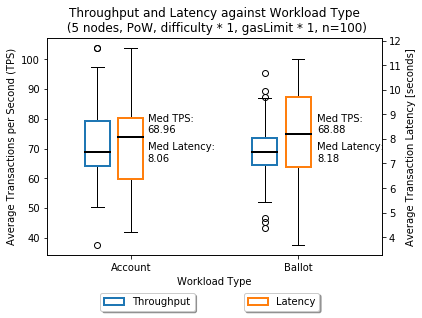

In [16]:
fig = plt.figure()

## the data
N = 2
## necessary variables
ind = np.arange(N)                # the x locations for the groups
#print(ind)
# Create an axes instance
ax1 = fig.add_subplot(111)

ax1.set_title("Throughput and Latency against Workload Type\n (5 nodes, PoW, difficulty * 1, gasLimit * 1, n=" + str(sample_size) + ")")
ax1.set_xlabel(xlabel)
ax1.set_ylabel("Average Transactions per Second (TPS)")

#print(objects)
#print(means_tps)

# Create the boxplot
bp = ax1.boxplot(data_to_plot_tps,labels=objects, positions=ind+0.1, patch_artist=True, manage_xticks=True)

ax2 = ax1.twinx()
bp2 = ax2.boxplot(data_to_plot_latency,labels=objects, positions=ind+0.3, patch_artist=True, manage_xticks=True)
#ax1.set_xticks(ind + 0.5/2)
ax2.set_ylabel("Average Transaction Latency [seconds]")
ax1.set_xticklabels(('Account', 'Ballot'))

## change outline color, fill color and linewidth of the boxes
for box in bp['boxes']:
    # change outline color
    box.set( color=color_tps, linewidth=2)
    # change fill color
    box.set( facecolor = 'w' )
    
## change color and linewidth of the medians
for median in bp['medians']:
    median.set(color="k", linewidth=2) 
    
## change outline color, fill color and linewidth of the boxes
for box in bp2['boxes']:
    # change outline color
    box.set( color=color_latency, linewidth=2)
    # change fill color
    box.set( facecolor = 'w' )
    
## change color and linewidth of the medians
for median in bp2['medians']:
    median.set(color="k", linewidth=2) 

plt.figtext(0.3575, 0.55, "Med TPS:\n" + str(round(data1_tps.median(),2)), color='black')
plt.figtext(0.3575, 0.45, 'Med Latency:\n' + str(round(data1_latency.median(),2)), color='black')

plt.figtext(0.75, 0.55, 'Med TPS:\n' + str(round(data2_tps.median(),2)), color='black')
plt.figtext(0.75, 0.45, 'Med Latency:\n' + str(round(data2_latency.median(),2)), color='black')

ax1.legend([bp["boxes"][0]],["Throughput"],bbox_to_anchor=(0.3, -0.15),fancybox=True,shadow=True,loc="upper center")
ax2.legend([bp2["boxes"][0]],["Latency"],bbox_to_anchor=(0.7, -0.15),fancybox=True,shadow=True,loc="upper center")

fig.savefig("result_workload_pow_combined_boxplot.svg", format="svg")

In [10]:
#https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html

from scipy import stats

k2, p = stats.normaltest(data1_tps)
alpha = 0.05
#H0 = data comes from a normal distribution
#if p values is less than alpha it is unlikely that the data comes from a normal distribution
print("p = {:g}".format(p))
if p < alpha:
    print("H0 rejected = x DOES NOT COME from a normal distribution")
else:
    print("H0 valid = x COMES from a normal distribution")
    

p = 0.308961
H0 valid = x COMES from a normal distribution


In [11]:
t,p = stats.ttest_ind(data1_tps,data2_tps,equal_var=False)

print("p = {:g}".format(p))
if(p<alpha):
    print("H0 is rejected = there IS a significant difference in Throughput")
else:
    print("H0 valid = there is NO significant difference in Throughput")


p = 0.264185
H0 valid = there is NO significant difference in Throughput


In [12]:
t,p = stats.ttest_ind(data1_latency,data2_latency,equal_var=False)

print("p = {:g}".format(p))
if(p<alpha):
    print("H0 is rejected = there IS a significant difference in Latency")
else:
    print("H0 valid = there is NO significant difference in Latency")


p = 0.310179
H0 valid = there is NO significant difference in Latency


In [13]:
timestamp_block_50=1545124754
timestamp_block_150=1545124862
timestamp_block_550=1545125308

average_block_frequency=(timestamp_block_550-timestamp_block_50)/500
print("Average Block Frequency was: " + str(average_block_frequency))

Average Block Frequency was: 1.108
